In [88]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numba import  njit
from scipy.stats import ncx2, ks_2samp, entropy, wilcoxon, chisquare
from typing import Literal

1. Design a process that stays in the interval $[a,b]$ and mean-reverts around $\frac{b-a}{с}$, $c \sim \mathcal{U}(a,b)$.

Generate a path and plot it in graph and add the mean line.

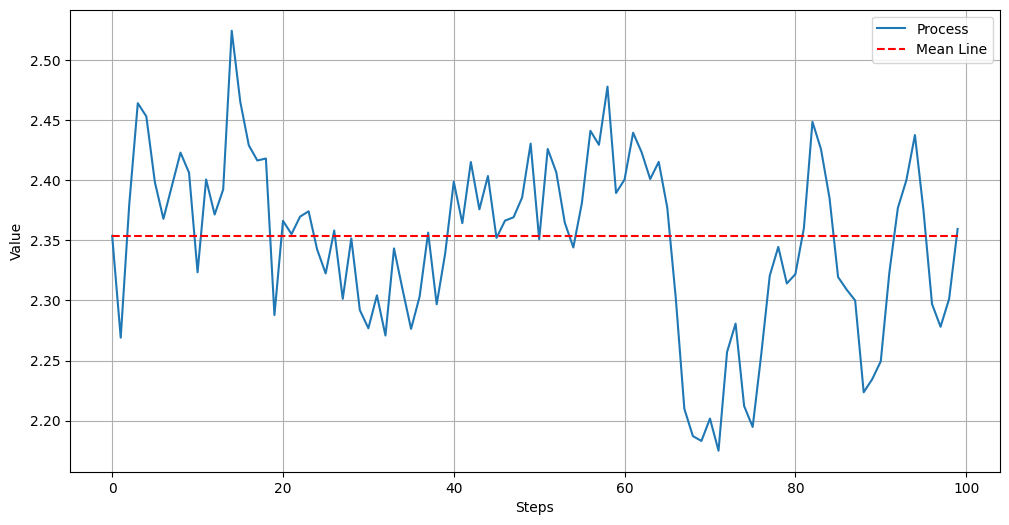

In [60]:
def StochasticProcessFor1(a, b, num_steps, k, sigma, seed=None):
    mu = np.random.uniform(a, b)
    x = np.zeros(num_steps)
    x[0] = mu

    for i in range(1, num_steps):
        xi = x[i-1] + k * (mu - x[i-1]) + sigma * np.random.randn()
        
        if xi < a:
            xi = a + (a - xi)
            
        elif xi > b:
            xi = b - (xi - b)

        x[i] = np.clip(xi, a, b)

    return x, mu

a = 0        
b = 10   
k = 0.2
steps = 100       
sigma = 0.05    

path, mu = StochasticProcessFor1(a, b, steps, k, sigma)
time = np.arange(num_steps)

plt.figure(figsize=(12, 6))
plt.plot(time, path, label='Process')
plt.hlines(mu, xmin=0, xmax=num_steps-1, colors='red', linestyles='dashed', label=f'Mean Line')
plt.xlabel('Steps')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

2. Simulate a Cox-Ingersoll-Ross (CIR) process
$$
dX_t = (6 - 2X_t)dt + θ\sqrt{X_t}dW_t, X(0)=1,
$$
where $θ = θ_1 = 1$ for $t < τ_0 = 0.6$ and $θ = θ_2$ for $t ≥ τ_0$, $t \in (0, 1)$.

Plot the simulated path, plot the shape of statistic $|\hat{D}_k|$ and
identify the change-point $k_0$ on a time-serie and compare result with $\tau_0$.

**Hint (Iacus, 2008, p. 212).** Consider the $\sigma(x)$ is constant and $b(x)$ can be estimated
$$
\hat{b}_n(x) = \frac{\sum_{i=0}^{n-1} K\left(\frac{x-X_i}{h_n}\right)(X_{i+1}-X_i)} {\Delta_n \sum_{i=0}^{n-1} K\left(\frac{x-X_i}{h_n}\right)},
$$
then use residuals
$$
Z_i = \frac{(X_{i+1} - X_i) - \hat{b}(X_i)\Delta_n}{\sqrt{\Delta_n}},
$$
and compute the statistic
$$
\hat{V}_k = \left(\frac{k(n-k)}{n^2}\right)^{1/2} \left(\frac{\hat{S}_{n-k}}{n-k}
- \frac{\hat{S}_k}{k}\right)
 = \frac{\hat{S}_n \hat{D}_k}{\sqrt{n-k}},
$$
where
$\hat{S}_k = \sum_{i=1}^k \hat{Z}_i^2$,
$\hat{S}_{n-k} = \sum_{i=k+1}^n \hat{Z}_i^2$, and $\hat{D}_k = \frac kn - \frac{\hat{S}_k}{\hat{S}_n}.$

Finally the change-point is identifed as the solution to
$$
\hat{k}_0 = \arg \min_k |\hat{D}_k|.
$$

Expected result is:

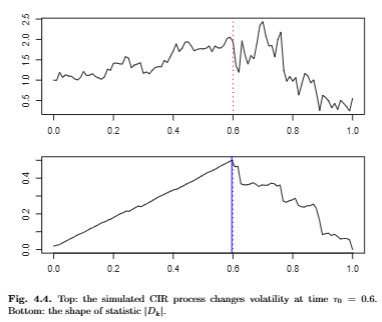

https://forecastegy.com/posts/change-point-detection-time-series-python/

https://github.com/amanahuja/change-detection-tutorial

In [72]:
# 1. Моделирование процесса CIR
def simulate_cir_process(total_time, num_steps, initial_value, rate1, rate2, change_point):
    time_interval = total_time / num_steps
    times = np.linspace(0, total_time, num_steps + 1)
    values = np.zeros(num_steps + 1)
    values[0] = initial_value

    for step in range(1, num_steps + 1):
        current_rate = rate1 if times[step - 1] < change_point else rate2
        random_innovation = np.random.normal(0, np.sqrt(time_interval))
        drift_component = (6 - 2 * values[step - 1]) * time_interval
        diffusion_component = current_rate * np.sqrt(max(values[step - 1], 0)) * random_innovation
        values[step] = max(values[step - 1] + drift_component + diffusion_component, 0)
    
    return times, values

# 2. Ядерная оценка плотности для b(x)
def kernel_density(x, data, bandwidth):
    gaussian_kernel = lambda u: np.exp(-u**2 / 2) / np.sqrt(2 * np.pi)
    kernel_values = gaussian_kernel((x - data) / bandwidth)
    return kernel_values / np.sum(kernel_values)

def estimate_drift_function(values, time_step, bandwidth):
    num_values = len(values) - 1
    drift_estimates = np.zeros(num_values)
    
    for idx in range(num_values):
        sample_value = values[idx]
        kernel_weights = kernel_density(sample_value, values[:-1], bandwidth)
        drift_estimates[idx] = np.sum(kernel_weights * (values[1:] - values[:-1])) / (time_step * np.sum(kernel_weights))
    
    return drift_estimates

# 3. Вычисление статистики D_k
def compute_d_statistic(values, drift_estimates, time_step):
    num_values = len(values) - 1
    residuals = (values[1:] - values[:-1] - drift_estimates * time_step) / np.sqrt(time_step)
    cumulative_squared_residuals = np.cumsum(residuals**2)
    total_residual_sum = cumulative_squared_residuals[-1]
    d_statistic = np.arange(1, num_values + 1) / num_values - cumulative_squared_residuals / total_residual_sum
    return np.abs(d_statistic), cumulative_squared_residuals


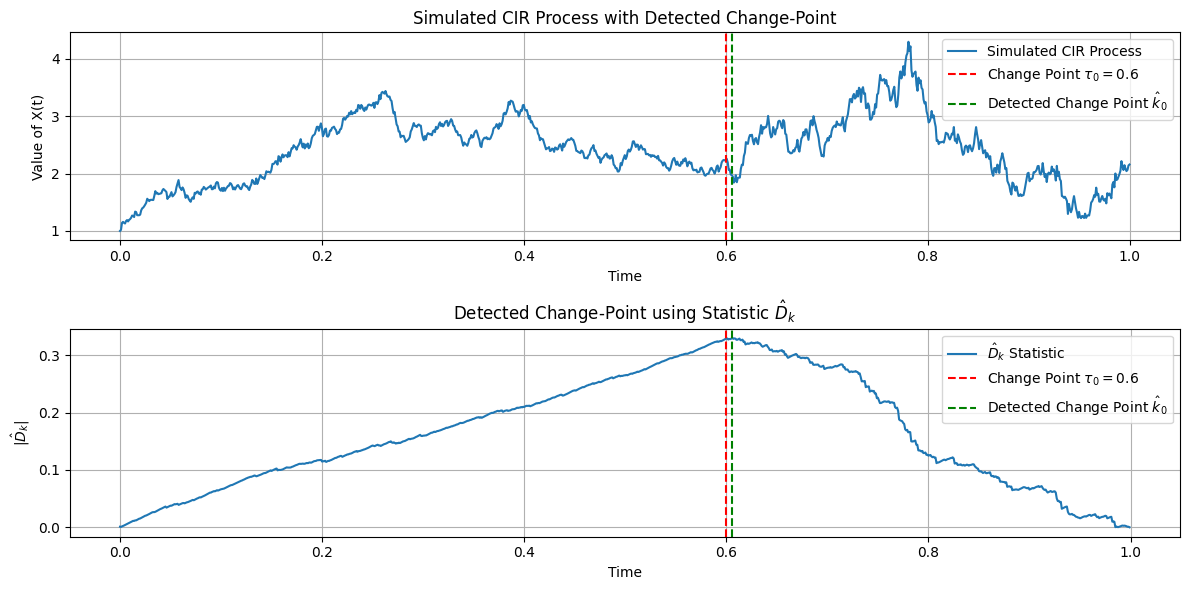

In [73]:
# 4. Симуляция данных и оценка
total_time = 1
num_steps = 1000
initial_value = 1
rate1 = 1.0
rate2 = 2.0
change_point = 0.6

# Генерация данных процесса CIR
times, values = simulate_cir_process(total_time, num_steps, initial_value, rate1, rate2, change_point)

# Оценка функции b(x)
bandwidth = 0.1
drift_estimates = estimate_drift_function(values, total_time / num_steps, bandwidth)

# Вычисление статистики D_k
d_statistic, cumulative_residuals = compute_d_statistic(values, drift_estimates, total_time / num_steps)

# Находим индекс для точки изменения
change_index = np.argmax(d_statistic)
change_time = times[change_index]

# Визуализация данных
plt.figure(figsize=(12, 6))

# График процесса CIR
plt.subplot(2, 1, 1)
plt.plot(times, values, label='Simulated CIR Process')
plt.axvline(x=change_point, color='red', linestyle='--', label=r'Change Point $\tau_0 = 0.6$')
plt.axvline(x=change_time, color='green', linestyle='--', label=r'Detected Change Point $\hat{k}_0$')
plt.title('Simulated CIR Process with Detected Change-Point')
plt.xlabel('Time')
plt.ylabel('Value of X(t)')
plt.legend()
plt.grid()

# График статистики D_k
plt.subplot(2, 1, 2)
plt.plot(times[:-1], d_statistic, label=r'$\hat{D}_k$ Statistic')
plt.axvline(x=change_point, color='red', linestyle='--', label=r'Change Point $\tau_0 = 0.6$')
plt.axvline(x=change_time, color='green', linestyle='--', label=r'Detected Change Point $\hat{k}_0$')
plt.title(r'Detected Change-Point using Statistic $\hat{D}_k$')
plt.xlabel('Time')
plt.ylabel(r'$|\hat{D}_k|$')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

3. Simulate and plot 100 trajectories of the process
$$
dX_t = (0.03tX_t – X^3_t)dt + 0.1dW_t
$$
with the 1st Milstein scheme, $x_0=0$, $t_0=0$, $T=100$, and $\Delta t=0.01$.

Add an average trajectory and confidence interval on the graph.

In [34]:
# your code
class StochasticProcessFor3:
    def __init__(self, T, Nx, Nt, init_state = None):
        self.T = T
        self.Nx = Nx # Number of trajectories
        self.Nt = Nt # Number of discretization steps
        self.init_state = self.DefaultInitState()
        if init_state is not None:
            self.init_state = init_state

        #Wiener Process by default
        self.bxt = lambda x, t: (0.03 * t * x - x**3) 
        self.sigmaxt = lambda x, t: 0.1
        self.bxt_x = lambda x, t: 0.03 * t - 3 * x **2
        self.bxt_xx = lambda x, t: - 6 * x
        self.sigmaxt_x = lambda x, t: 0
        self.sigmaxt_xx = lambda x, t: 0

    def DefaultInitState(self):
        return np.zeros(self.Nx)

    def Milstein1Solution(self):
        dt = self.T / self.Nt
        dwt = dwt = np.random.normal(0, 1, size = (self.Nt, self.Nx)) * np.sqrt(self.T/self.Nt)
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + self.bxt(x_data[i - 1], t_data[i - 1]) * dt + \
                            self.sigmaxt(x_data[i - 1], t_data[i - 1]) * dwt[i - 1] + \
                            1/2 * self.sigmaxt(x_data[i - 1], t_data[i - 1]) * \
                            self.sigmaxt_x(x_data[i - 1], t_data[i - 1]) * (dwt[i - 1]**2 - dt)
        return t_data, x_data


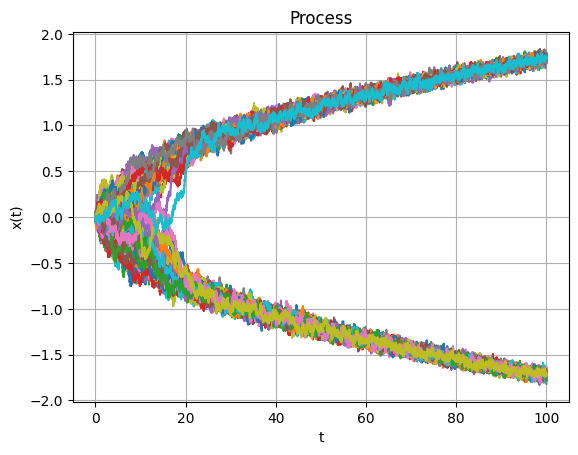

In [37]:
Nx = 100
Nt = 10000

T = 100

params_OU = [1, 1, 0.5]
params_BSM = [0.3, 0.1]
params_CIR = [0.4, 0.3, 0.2]

init_state = 0.5 * np.ones(Nx)

Process = StochasticProcessFor3(T=T, Nx=Nx, Nt=Nt)

t_data, x_data = Process.Milstein1Solution()
plt.plot(t_data, x_data)

plt.title("Process")
# plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

4. Implement a non-parametric drift and diffusion estimators for the Ornstein-Uhlenbeck model
$$
dX_t = (θ_1 - θ_2X_t)dt + θ_3 dW_t,
X(0) = 10,  θ = (0, 3, 2).
$$

Use
*   uniform kernel $K(u) = 1/2$,
*   Epanechnikov (parabolic) kernel $K(u) = \frac{3}{4}(1 - u^2)$,
*   Gaussian kernel $K(u) = \frac{1}{\sqrt{2\pi}} \exp \left(-\frac{1}{2}u^2\right)$,

and plot the estimations on the graph.


In [91]:
# Parameters for the OU process 
theta = (0, 3, 2)  # (theta1, theta2, theta3)
X0 = 10
T = 10  # total time
dt = 0.01  # time step
N = int(T / dt)  # number of steps
time = np.linspace(0, T, N)

# Generate the Ornstein-Uhlenbeck process using Euler-Maruyama
X = np.zeros(N)
X[0] = X0
dW = np.sqrt(dt) * np.random.randn(N - 1)

for i in range(1, N):
    X[i] = X[i - 1] + (theta[0] - theta[1] * X[i - 1]) * dt + theta[2] * dW[i - 1]

# Bandwidth for kernel estimation
h = 0.5

# Define different kernels
kernels = {
    'Uniform': lambda u: 0.5 * (np.abs(u) <= 1),
    'Epanechnikov': lambda u: 0.75 * (1 - u**2) * (np.abs(u) <= 1),
    'Gaussian': lambda u: norm.pdf(u)
}

# Non-parametric estimation of drift and diffusion
def compute_estimate(X, X_grid, kernel, estimation_type):
    estimate = []
    for x0 in X_grid:
        weights = kernel((X[:-1] - x0) / h)
        if estimation_type == 'drift':
            weighted_dX = weights * (X[1:] - X[:-1]) / dt
            estimate.append(np.sum(weighted_dX) / np.sum(weights))
        elif estimation_type == 'diffusion':
            weighted_diffusion = weights * ((X[1:] - X[:-1]) ** 2 / dt)
            estimate.append(np.sqrt(np.sum(weighted_diffusion) / np.sum(weights)))
    return np.array(estimate)


C:\Users\yakov\AppData\Local\Temp\ipykernel_10348\3904670385.py:34: RuntimeWarning: invalid value encountered in scalar divide
  estimate.append(np.sum(weighted_dX) / np.sum(weights))
C:\Users\yakov\AppData\Local\Temp\ipykernel_10348\3904670385.py:37: RuntimeWarning: invalid value encountered in scalar divide
  estimate.append(np.sqrt(np.sum(weighted_diffusion) / np.sum(weights)))


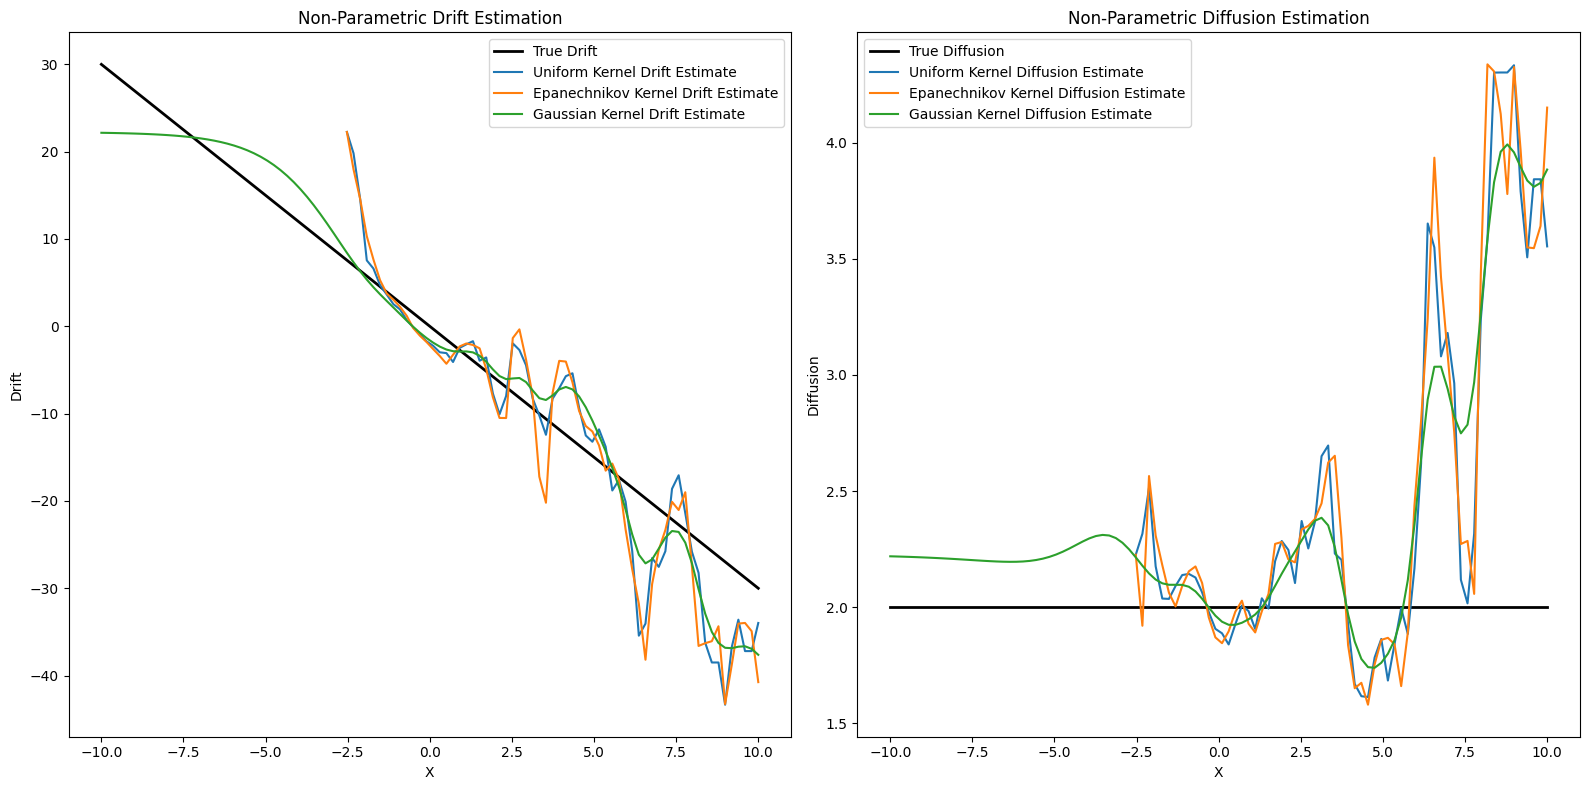

In [92]:
# Define the grid for X values
X_grid = np.linspace(-10, 10, 100)

# Compute drift and diffusion estimates using each kernel
drift_estimates = {key: compute_estimate(X, X_grid, kernel, 'drift') for key, kernel in kernels.items()}
diffusion_estimates = {key: compute_estimate(X, X_grid, kernel, 'diffusion') for key, kernel in kernels.items()}

# True drift and diffusion values
true_drift = theta[0] - theta[1] * X_grid
true_diffusion = np.full_like(X_grid, theta[2])

# Plot the results
plt.figure(figsize=(16, 8))

# Drift estimation plot
plt.subplot(1, 2, 1)
plt.plot(X_grid, true_drift, label="True Drift", color="black", linewidth=2)
for name, drift in drift_estimates.items():
    plt.plot(X_grid, drift, label=f"{name} Kernel Drift Estimate")
plt.xlabel("X")
plt.ylabel("Drift")
plt.title("Non-Parametric Drift Estimation")
plt.legend()

# Diffusion estimation plot
plt.subplot(1, 2, 2)
plt.plot(X_grid, true_diffusion, label="True Diffusion", color="black", linewidth=2)
for name, diffusion in diffusion_estimates.items():
    plt.plot(X_grid, diffusion, label=f"{name} Kernel Diffusion Estimate")
plt.xlabel("X")
plt.ylabel("Diffusion")
plt.title("Non-Parametric Diffusion Estimation")
plt.legend()

plt.tight_layout()
plt.show()

5. Estimate the parameters of a random process. As candidates use
*   Ornstein-Uhlenbeck process,
*   Geometric Brownian motion process,
*   Cox-Ingersoll-Ross process.

Plot three models in a graph and choose the best one. Provide the proof of your solution.

Time-series (*. csv) in the [folder](https://drive.google.com/drive/folders/1tzHl3-7jMtRiGgFe5suqT2CzftZ0o9cB?usp=sharing).

<Axes: >

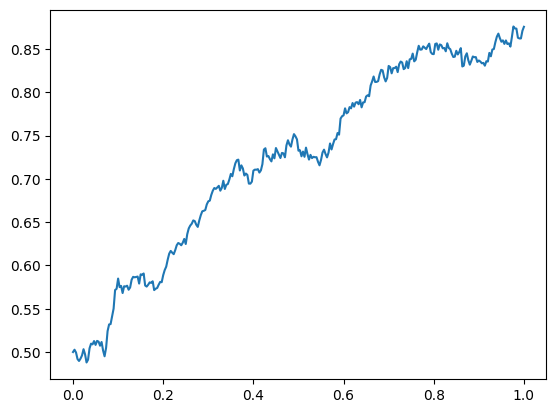

In [80]:
from scipy import stats

data = pd.read_csv('6.csv', index_col=0)['0'].values
n = len(data)
t = np.linspace(0, 1, n)

time_series = pd.read_csv('6.csv', index_col=0)['0']
time_series.plot()

In [81]:
# Вспомогательные функции для моделирования различных процессов
def generate_ou(mu, theta, sigma, t, x0):
    dt = t[1] - t[0]
    x = np.zeros(len(t))
    x[0] = x0
    for i in range(1, len(t)):
        dx = -theta * (x[i-1] - mu) * dt + sigma * np.sqrt(dt) * np.random.normal()
        x[i] = x[i-1] + dx
    return x

def generate_gbm(mu, sigma, t, x0):
    dt = t[1] - t[0]
    x = np.zeros(len(t))
    x[0] = x0
    for i in range(1, len(t)):
        dx = mu * x[i-1] * dt + sigma * x[i-1] * np.sqrt(dt) * np.random.normal()
        x[i] = x[i-1] + dx
    return x

def generate_cir(theta, kappa, sigma, t, x0, epsilon=1e-6):
    dt = t[1] - t[0]
    x = np.zeros(len(t))
    x[0] = x0
    for i in range(1, len(t)):
        dx = kappa * (theta - x[i-1]) * dt + sigma * np.sqrt(np.maximum(x[i-1], epsilon) * dt) * np.random.normal()
        x[i] = x[i-1] + dx
        x[i] = np.maximum(x[i], epsilon)
    return x

def compute_aic(data, model_func, params, t, x0):
    simulated_data = model_func(*params, t, x0)
    residuals = data - simulated_data
    rss = np.sum(residuals ** 2)  # остаточная сумма квадратов
    n_params = len(params)
    n = len(data)
    
    aic = n * np.log(rss / n) + 2 * n_params  # AIC
    return aic

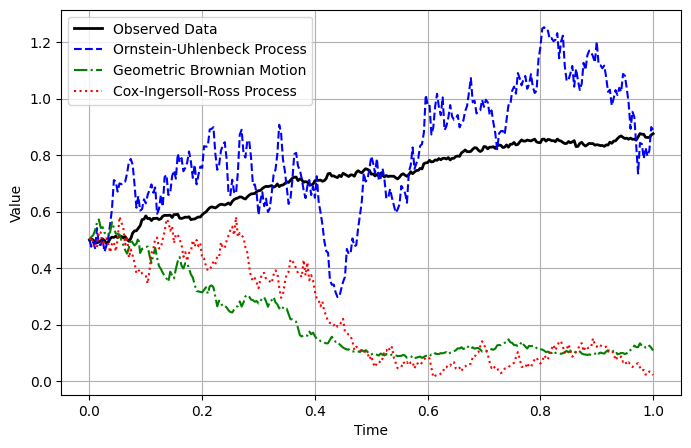

AIC for OU Process: -857.1745
AIC for GBM Process: -541.5165
AIC for CIR Process: -1078.2884
The best model based on AIC is: CIR with AIC: -1078.2884


In [83]:
# Реализация генерации случайных процессов и подбор параметров
params_ou = [0.5, 1.0, 0.8]
params_gbm = [0.05, 0.8]
params_cir = [0.5, 0.5, 0.8]
x0 = data[0]

# Симуляции данных с различными моделями
ou_sim = generate_ou(*params_ou, t, x0)
gbm_sim = generate_gbm(*params_gbm, t, x0)
cir_sim = generate_cir(*params_cir, t, x0)

# Строим график исходных и смоделированных данных
plt.figure(figsize=(8, 5))
plt.plot(t, data, label='Observed Data', color='black', linewidth=2)
plt.plot(t, ou_sim, label='Ornstein-Uhlenbeck Process', color='blue', linestyle='--')
plt.plot(t, gbm_sim, label='Geometric Brownian Motion', color='green', linestyle='-.')
plt.plot(t, cir_sim, label='Cox-Ingersoll-Ross Process', color='red', linestyle=':')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Оценка AIC для каждой модели
aic_ou = compute_aic(data, generate_ou, params_ou, t, x0)
aic_gbm = compute_aic(data, generate_gbm, params_gbm, t, x0)
aic_cir = compute_aic(data, generate_cir, params_cir, t, x0)

# Выводим AIC для каждой модели
print(f'AIC for OU Process: {aic_ou:.4f}')
print(f'AIC for GBM Process: {aic_gbm:.4f}')
print(f'AIC for CIR Process: {aic_cir:.4f}')

# Определение наилучшей модели по AIC
best_model_aic = min([(aic_ou, 'OU'), (aic_gbm, 'GBM'), (aic_cir, 'CIR')], key=lambda x: x[0])
print(f"The best model based on AIC is: {best_model_aic[1]} with AIC: {best_model_aic[0]:.4f}")